In [172]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [181]:
pcp_facilities_gdf = gpd.read_file('./data/pcp_facilities_32counties.geojson')
pcp_medicaid_tracts_gdf = gpd.read_file('./data/pcp_medicaid_tracts.geojson')
pcp_commercial_tracts_gdf = gpd.read_file('./data/pcp_commercial_tracts.geojson')
nys_counties_gdf = gpd.read_file('./data/NYS_Civil_Boundaries_Counties.geojson')

In [182]:
# Match CRS for all GeoDataFrames
nys_counties_gdf = nys_counties_gdf.to_crs(pcp_medicaid_tracts_gdf.crs)
pcp_facilities_gdf = pcp_facilities_gdf.to_crs(pcp_medicaid_tracts_gdf.crs)

In [217]:
# Combine medicaid, commercial tracts
demand_tracts_gdf = pcp_medicaid_tracts_gdf
demand_tracts_gdf["commercial"] = pcp_commercial_tracts_gdf["commercial"]
columns_to_keep = ['COUNTYFP', 'TRACTCE', 'GEOID', 'NAMELSAD', 'ALAND', 'AWATER', 'geometry', 'medicaid', 'commercial']
demand_tracts_gdf = demand_tracts_gdf[columns_to_keep]

# Filter 32 counties for the demand_tracts_gdf
counties_to_keep = ['013', '029', '037', '069', '101', '097', '109', '107', '023', '011', '067', '075', '065', '049', '089', '041', '113', '057', '083', '001', '039', '111', '105', '071', '087', '079', '119', '005', '061', '081', '047', '085']
demand_tracts_gdf = demand_tracts_gdf.loc[demand_tracts_gdf['COUNTYFP'].isin(counties_to_keep), columns_to_keep]

# Filter 32 counties for the nys_counties_gdf
counties_to_keep = ['Greene', 'Montgomery', 'Richmond', 'Queens', 'Kings', 'New York', 'Bronx',
 'Warren', 'Westchester', 'Rockland', 'Orange', 'Putnam', 'Sullivan', 'Ulster',
 'Tioga', 'Erie', 'Chautauqua', 'Steuben', 'Schuyler', 'Tompkins', 'Albany',
 'Cortland', 'Rensselaer', 'Ontario', 'Cayuga', 'Onondaga', 'Genesee', 'Oneida',
 'Oswego', 'Hamilton', 'Lewis', 'St Lawrence']
filtered_nys_counties_gdf = nys_counties_gdf.loc[nys_counties_gdf['NAME'].isin(counties_to_keep)]

# Filter population outliers
filtered_demand_tracts_gdf = demand_tracts_gdf[
    (demand_tracts_gdf['medicaid'] + demand_tracts_gdf['commercial']) / demand_tracts_gdf["ALAND"] * 1000000 > 10]

# Add healthcare remaining capacity to pcp_facilities_gdf (1pcp can serve 3000 patients)
pcp_facilities_gdf.loc[:, "remaining_capacity_medicaid"] = pcp_facilities_gdf["pcp_medicaid"] * 3000
pcp_facilities_gdf.loc[:, "remaining_capacity_commercial"] = pcp_facilities_gdf["pcp_commercial"] * 3000

# Add unserved population to filtered_demand_tracts_gdf
filtered_demand_tracts_gdf.loc[:, "unserved_medicaid"] = filtered_demand_tracts_gdf["medicaid"]
filtered_demand_tracts_gdf.loc[:, "unserved_commercial"] = filtered_demand_tracts_gdf["commercial"]

# Add centroids of polygons to filtered_demand_tracts_gdf
filtered_demand_tracts_gdf['centroid'] = filtered_demand_tracts_gdf.geometry.centroid

# Deep copy datasets
copy_demand_tracts_gdf = filtered_demand_tracts_gdf.copy(deep=True)
copy_pcp_facilities_gdf = pcp_facilities_gdf.copy(deep=True)

# Ensure remaining_capacity_{insurance_type} values are numeric
copy_pcp_facilities_gdf["remaining_capacity_medicaid"] = pd.to_numeric(copy_pcp_facilities_gdf['remaining_capacity_medicaid'], errors='coerce')
copy_pcp_facilities_gdf["remaining_capacity_commercial"] = pd.to_numeric(copy_pcp_facilities_gdf['remaining_capacity_commercial'], errors='coerce')

C:\Users\kl3539\AppData\Local\miniconda3\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\kl3539\AppData\Local\miniconda3\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\kl3539\AppData\Local\miniconda3\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

### Get the closest facility / Compute healthcare capacity

In [211]:
from shapely.ops import nearest_points

def find_closest_facility(centroid, facilities_gdf, insurance_type, distance_limit_km=15):
    # Convert the distance limit from kilometers to feet for EPSG:32016
    distance_limit_feet = distance_limit_km * 1000 * 3.28084  # 1 km = 1000 meters, 1 meter = 3.28084 feet
    
    # Determine the column name for remaining capacity based on the insurance type
    remaining_capacity_col = f'remaining_capacity_{insurance_type.lower()}'
    
    # Create a buffer around the centroid representing the search area, in feet
    search_area = centroid.buffer(distance_limit_feet)
    
    # Filter facilities within the search area AND with specified remaining capacity >= 1
    facilities_within_limit = facilities_gdf[facilities_gdf.intersects(search_area) & (facilities_gdf[remaining_capacity_col] >= 1)]
    #print(facilities_within_limit)
    
    if not facilities_within_limit.empty:
        # Calculate the nearest point within the filtered facilities
        closest_facility = nearest_points(centroid, facilities_within_limit.unary_union)[1]
        # Find the index of the closest facility in the original GeoDataFrame
        closest_facility_index = facilities_gdf.geometry == closest_facility
        return facilities_gdf[closest_facility_index].index.values[0]
    else:
        # Return None or an appropriate value if no suitable facilities are within the distance limit
        return np.nan

def compute_healthcare_capacity(tracts_gdf, facilities_gdf, insurance_type):
    # Determine the column names based on the insurance type (Medicaid or Commercial)
    closest_facility_col = f'closest_facility_index_{insurance_type.lower()}'
    remaining_capacity_col = f'remaining_capacity_{insurance_type.lower()}'
    unserved_col = f'unserved_{insurance_type.lower()}'
    
    for index, tract in tracts_gdf.iterrows():
        facility_index = tract[closest_facility_col]
        if pd.notna(facility_index):
            facility = facilities_gdf.iloc[int(facility_index)]  # Ensure the facility index is treated as integer
            if tract[unserved_col] < facility[remaining_capacity_col]:
                tracts_gdf.loc[index, unserved_col] = 0
                facilities_gdf.loc[int(facility_index), remaining_capacity_col] = facility[remaining_capacity_col] - tract[unserved_col]
            else:
                facilities_gdf.loc[int(facility_index), remaining_capacity_col] = 0
                tracts_gdf.loc[index, unserved_col] = tract[unserved_col] - facility[remaining_capacity_col]


# Find the closest facility for Medicaid
copy_demand_tracts_gdf['closest_facility_index_medicaid'] = copy_demand_tracts_gdf['centroid'].apply(lambda x: find_closest_facility(x, copy_pcp_facilities_gdf, 'medicaid'))
# Find the closest facility for Commercial
copy_demand_tracts_gdf['closest_facility_index_commercial'] = copy_demand_tracts_gdf['centroid'].apply(lambda x: find_closest_facility(x, copy_pcp_facilities_gdf, 'commercial'))
# Ensure index datatype is integer
copy_demand_tracts_gdf['closest_facility_index_medicaid']

# print closest facilities
print('medicaid facilities\n', copy_demand_tracts_gdf['closest_facility_index_medicaid'])
print('commercial facilities\n', copy_demand_tracts_gdf['closest_facility_index_commercial'])

# Medicaid: print before execution
print('')
for index, tract in copy_demand_tracts_gdf.iterrows():
    print('medicaid unserved before', tract.unserved_medicaid)
facilities_medicaid = copy_demand_tracts_gdf['closest_facility_index_medicaid'].unique()
for index in facilities_medicaid:
    if (pd.notna(index)):
        print('medicaid remaining before', copy_pcp_facilities_gdf.iloc[int(index)].remaining_capacity_medicaid)
# Commercial: print before execution
for index, tract in copy_demand_tracts_gdf.iterrows():
    print('commercial unserved before', tract.unserved_commercial)
facilities_commercial = copy_demand_tracts_gdf['closest_facility_index_commercial'].unique()
for index in facilities_commercial:
    if (pd.notna(index)):
        print('commercial remaining before', copy_pcp_facilities_gdf.iloc[int(index)].remaining_capacity_commercial)


# Compute healthcare capacity for Medicaid
compute_healthcare_capacity(copy_demand_tracts_gdf, copy_pcp_facilities_gdf, 'Medicaid')
# Compute healthcare capacity for Commercial
compute_healthcare_capacity(copy_demand_tracts_gdf, copy_pcp_facilities_gdf, 'Commercial')


# Medicaid: print after execution
print('')
for index, tract in copy_demand_tracts_gdf.iterrows():
    print('medicaid unserved after', tract.unserved_medicaid)
facilities_medicaid = copy_demand_tracts_gdf['closest_facility_index_medicaid'].unique()
for index in facilities_medicaid:
    if (pd.notna(index)):
        print('medicaid remaining after', copy_pcp_facilities_gdf.iloc[int(index)].remaining_capacity_medicaid)
# Commercial: print after execution
for index, tract in copy_demand_tracts_gdf.iterrows():
    print('commercial unserved after', tract.unserved_commercial)
facilities_commercial = copy_demand_tracts_gdf['closest_facility_index_commercial'].unique()
for index in facilities_commercial:
    if (pd.notna(index)):
        print('commercial remaining after', copy_pcp_facilities_gdf.iloc[int(index)].remaining_capacity_commercial)

medicaid facilities
 49       7102.0
114     12755.0
152      7817.0
197     10740.0
200     10740.0
         ...   
5180        NaN
5183    12755.0
5184    12788.0
5186    12755.0
5188    12795.0
Name: closest_facility_index_medicaid, Length: 139, dtype: float64
commercial facilities
 49       7102.0
114     12754.0
152      7780.0
197     10741.0
200     10741.0
         ...   
5180    12794.0
5183    12754.0
5184    12788.0
5186    12754.0
5188    12794.0
Name: closest_facility_index_commercial, Length: 139, dtype: float64

medicaid unserved before 13
medicaid unserved before 201
medicaid unserved before 13
medicaid unserved before 304
medicaid unserved before 356
medicaid unserved before 437
medicaid unserved before 153
medicaid unserved before 149
medicaid unserved before 223
medicaid unserved before 82
medicaid unserved before 238
medicaid unserved before 123
medicaid unserved before 218
medicaid unserved before 13
medicaid unserved before 227
medicaid unserved before 213
medicai

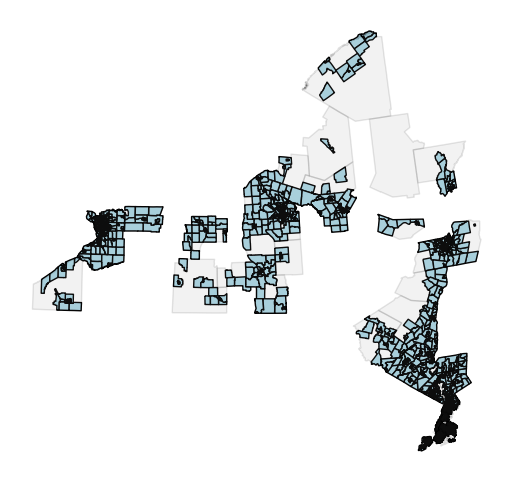

3466


In [218]:
# Filter copy_demand_tracts_gdf for polygons with 'unserved_commercial' > 0
filtered_copy_demand_tracts_gdf = copy_demand_tracts_gdf[copy_demand_tracts_gdf['unserved_commercial'] > 0]

# Plot the filtered GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed

# Plot only filtered tracts with 'unserved_commercial' > 0
filtered_copy_demand_tracts_gdf.plot(ax=ax, color='lightblue', edgecolor='black')

# Plot the New York State counties for context
filtered_nys_counties_gdf.plot(ax=ax, color='grey', edgecolor='black', alpha=0.1)

# Remove axis for a cleaner look
plt.axis('off')

# Show the plot
plt.show()

# If you want to print the length of filtered_copy_demand_tracts_gdf instead of filtered_demand_tracts_gdf
print(len(filtered_copy_demand_tracts_gdf))